In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import glob
import time
from lesson_functions import *

%matplotlib inline

## Load Data

In [2]:
'''
Display number of images
'''

vehicle_images = glob.glob('vehicles/**/*.png')
non_vehicle_images = glob.glob('non-vehicles/**/*.png')
print('vehicle images number: ', len(vehicle_images))
print('non vehicle images number: ', len(non_vehicle_images))

vehicle images number:  8792
non vehicle images number:  8968


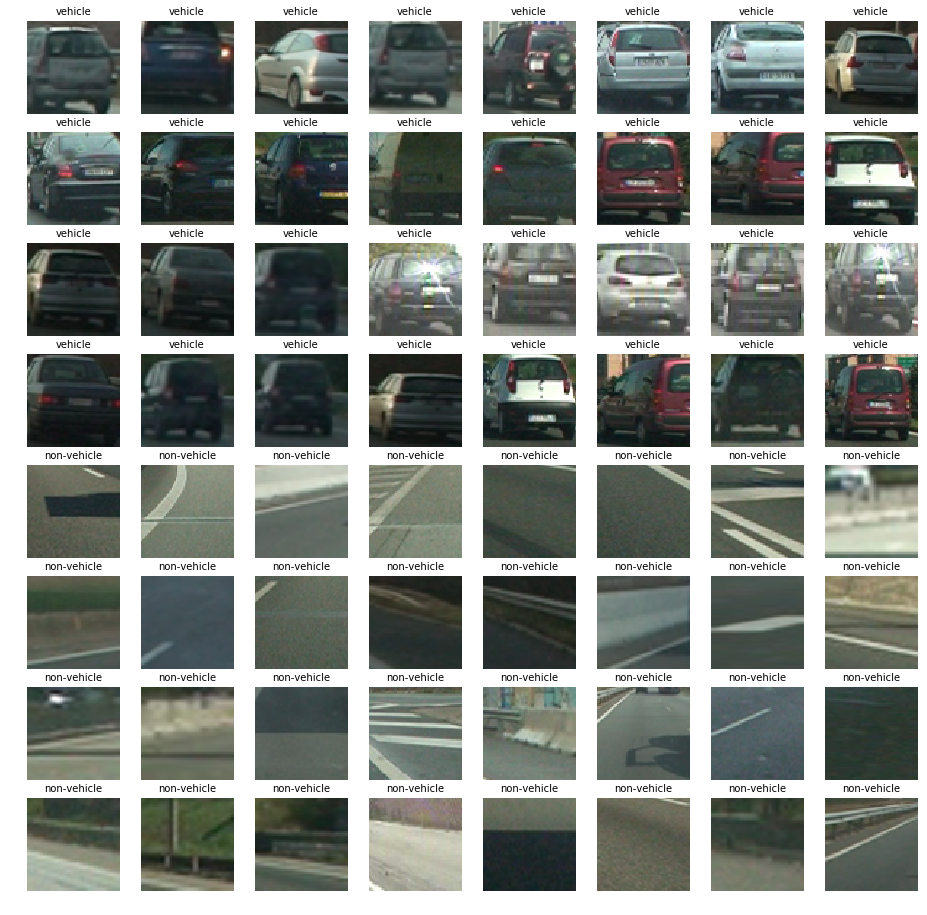

In [3]:
'''
Display traning images
'''

# Prepare matplotlib for plot
fig, axs = plt.subplots(8,8, figsize=(16, 16))
axs = axs.ravel()

# Display image data
# The reason why I convert color from BGR to RGB is jupyter notebook can't show image RGB by default settings
for i in np.arange(32):
    img = cv2.imread(vehicle_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(non_vehicle_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-vehicle', fontsize=10)
    axs[i].imshow(img)

## Histogram of Oriented Gradients (HOG)

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'Car HOG')

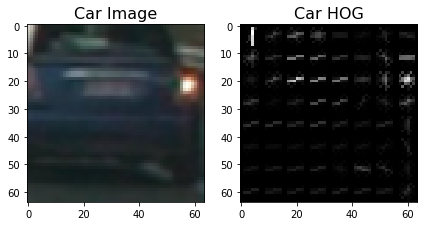

In [5]:
vehicle_image = mpimg.imread(vehicle_images[1])
features, hog_image = get_hog_features(vehicle_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(vehicle_image)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)

In [6]:
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, check_parameter=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if check_parameter == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)  
        else:
            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
                # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))    
    # Return list of feature vectors
    return features

In [7]:
cars = vehicle_images
notcars = non_vehicle_images

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

In [8]:


colorspaces = ['RGB'] #, 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'
orients = [8, 9, 10]
pix_per_cells = [7, 8, 9]
cell_per_blocks = [1, 2, 3]
hog_channels = [0, 1, 'ALL']
spatial_size=[16, 16]
hist_bins=16

###############
# for debug
#colorspaces = ['RGB', 'HSV']
#orients = [9]
#pix_per_cells = [8]
#cell_per_blocks = [2]
#hog_channels = 'ALL'
###############

best_score = 0

for colorspace in colorspaces:
    for orient in orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                for hog_channel in hog_channels:
                
                    t=time.time()
                    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)
                    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)
                    t2 = time.time()

                    # Create an array stack of feature vectors
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
                    scaled_X = X_scaler.transform(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, y, test_size=0.2, random_state=rand_state)
                    # Use a linear SVC 
                    svc = LinearSVC()
                    # Check the training time for the SVC
                    t3=time.time()
                    svc.fit(X_train, y_train)
                    t4 = time.time()
                    # Check the score of the SVC
                    svc_score = round(svc.score(X_test, y_test), 4)
                    if best_score < svc_score:
                        best_score = svc_score
                        best_orient = orient
                        best_pix_per_cell = pix_per_cell
                        best_cell_per_block = cell_per_block
                        best_color_space = colorspace
                        best_hog_channel = hog_channel
                        seconds_to_extrace_hog = str(round(t2-t, 2)) + ' Seconds to extract HOG features...'
                        feature_vector_length = 'Feature vector length: ' +  str(len(X_train[0]))
                        seconds_to_train_svc = str(round(t3-t4, 2)) + 'Seconds to train SVC...'                    
                        # Check the prediction time for a single sample
                        t5=time.time()
                        n_predict = 10
                        my_svc_predicts = 'My SVC predicts: ' + str(svc.predict(X_test[0:n_predict]))
                        features_and_labels = 'For these' + str(n_predict) + 'labels: ' + str(y_test[0:n_predict])
                        t6 = time.time()
                        seconds_to_predict = str(round(t6-t5, 5)) + ' Seconds to predict' + str(n_predict) + ' labels with SVC'
print('Test Accuracy of SVC = ', best_score)
print('Using:',best_orient,'orientations',best_pix_per_cell,'pixels per cell and', best_cell_per_block,'cells per block', best_color_space, 'is best color space', best_hog_channel, 'is best hog channel')
print(seconds_to_extrace_hog)
print(feature_vector_length)
print(seconds_to_train_svc)
print(my_svc_predicts)
print(features_and_labels)
print(seconds_to_predict)

/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of SVC =  1.0
Using: 8 orientations 8 pixels per cell and 1 cells per block RGB is best color space 0 is best hog channel
1.67 Seconds to extract HOG features...
Feature vector length: 3680
-0.48Seconds to train SVC...
My SVC predicts: [1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
For these10labels: [1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
0.00038 Seconds to predict10 labels with SVC


In [9]:
colorspace = 'RGB'
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 1
spatial_size=(16, 16)
hist_bins=16

best_car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel)
best_notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel)

# Create an array stack of feature vectors
# Appear error with spatial_feat=True and hist_feat=True
best_X = np.vstack((best_car_features, best_notcar_features)).astype(np.float64)
# Fit a per-column scaler
best_X_scaler = StandardScaler().fit(best_X)
# Apply the scaler to X
best_scaled_X = best_X_scaler.transform(best_X)

# Define the labels vector
best_y = np.hstack((np.ones(len(best_car_features)), np.zeros(len(best_notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
best_X_train, best_X_test, best_y_train, best_y_test = train_test_split(
    best_scaled_X, best_y, test_size=0.2, random_state=rand_state)
# Use a linear SVC 
best_svc = LinearSVC()
# Check the training time for the SVC
best_svc.fit(best_X_train, best_y_train)
print(best_svc.score(best_X_test, best_y_test))

/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.995


## Adjust Windows

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [13]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#cars = vehicle_images
#notcars = non_vehicle_images

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 10  # HOG orientations
#pix_per_cell = 7 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 1 # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# StandardScaler() is for normalization
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1328
0.07 Seconds to train SVC...
Test Accuracy of SVC =  1.0


/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


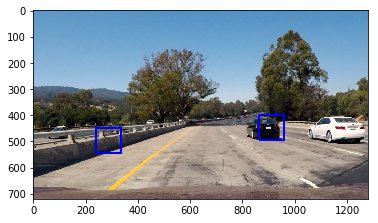

In [14]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, cspace):
    draw_img = np.copy(img)
    # RGB (Red, Green, Blue) are 8 bit each.
    # The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # The combination range is 256*256*256.
    # By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    '''
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    '''
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)  
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    # nxblocks is value that image width is devided by pixcel per cell, nyblocks is height one.
    # So, it means number of cell on one row and line.
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # nblocks_per_window is nblocks per window (now, block is same as cell.)
    # So, it means how many cells there are in one window.
    window = 64
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) -  1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    # nxsteps is total step about window(same as window).
    # Deduct one blocks from total blcoks, then devided by number of cell when windows slide.
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step# + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step# + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
              
            '''
            test_prediction = svc.predict(hog_features)
                
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            '''
                
    return draw_img

In [16]:
img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 656
scale = 1.5

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, color_space)

plt.imshow(out_img)

/Users/yoheitaonishi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,1208) (1328,) (1,1208) 

In [12]:
#false positive

## Multiple Detection (Heat-Map)

## Video Pipline